In [160]:
import pandas as pd
import numpy as np
import traffic
from traffic.core import Traffic
from traffic.data import opensky
from traffic.data import airports
import matplotlib.pyplot as plt
import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

***
# Download and preprocessing of trajs
***

In [161]:
airport_str = 'LSZH'

### Downloading trajs

In [162]:
start = "2024-07-01 00:00"
stop = "2024-07-02 23:59"

timestamps = pd.date_range(start, stop, freq="4h")
data = []
for t1, t2 in zip(timestamps[:-1], timestamps[1:]):
        tmp = opensky.history(start=str(t1), stop=str(t2), bounds=airports[airport_str].shape.convex_hull.buffer(0.1))
        if tmp is not None:
            data.append(tmp.data)
        

trajs = pd.concat(data)
trajs = Traffic(trajs)

### Preprocessing and pickling

In [163]:
# Reduce to lat/lon & altitude of interest
gnd_trajs = trajs.query('altitude<4000 or onground')
gnd_trajs = gnd_trajs.assign_id().resample('1s').eval(max_workers=8, desc='resampling')
gnd_trajs = gnd_trajs.aircraft_data()
gnd_trajs = gnd_trajs.cumulative_distance().eval(max_workers=8, desc='cumdist')

gnd_trajs.to_pickle(airport_str+'_raw.pkl')

resampling:   0%|          | 0/2373 [00:00<?, ?it/s]

cumdist:   0%|          | 0/2373 [00:00<?, ?it/s]

## Load gnd_trajs from Pickle (only if required)

In [4]:
gnd_trajs = Traffic.from_file(airport_str+'.pkl')

*** 
# Define Geometries for Runways and Stands
***

In [164]:
from shapely.geometry import LineString
import numpy as np
from cartes.crs import EuroPP
import cartopy.crs as ccrs
data_proj = ccrs.PlateCarree()


# Function to extend a point in the direction of another point
def extend_point(p1, p2, distance):
    # Calculate direction vector
    direction = np.array(p2) - np.array(p1)
    direction = direction / np.linalg.norm(direction)  # Normalize the vector
    # Extend the point
    new_point = np.array(p1) - direction * distance
    return tuple(new_point)

# Create Runway Geometries
rwys = []
idx = [0, 2, 4]

for i in idx:

    lat1 = airports[airport_str].runways.data.latitude[i]
    lon1 = airports[airport_str].runways.data.longitude[i]
    lat2 = airports[airport_str].runways.data.latitude[i+1]
    lon2 = airports[airport_str].runways.data.longitude[i+1]


    # Define the coordinates of the two points
    point1 = (lon1, lat1)
    point2 = (lon2, lat2)

    # Create a LineString object
    rwy = LineString([point1, point2])

    # Extend both ends of the line
    extension_distance = 0.002  # Adjust this value as needed
    rwy_extended = LineString([extend_point(point2, point1, extension_distance),
                            extend_point(point1, point2, extension_distance)])


    rwy_extended = rwy_extended.buffer(distance=0.0007, cap_style='square')

    rwys.append(rwy_extended)






In [165]:
from shapely.geometry import Polygon
data_proj = ccrs.PlateCarree()

stands = []

# Dock E
stands.append(Polygon(shell=((8.559361, 47.461887),
                             (8.549978, 47.462542),
                             (8.551437, 47.460347),
                             (8.559075, 47.459822))))

# Dock A
stands.append(Polygon(shell=((8.555001, 47.454855),
                             (8.556140, 47.453175),
                             (8.560965, 47.452810),
                             (8.562083, 47.454330))))

# Dock B
stands.append(Polygon(shell=((8.560488, 47.451963),
                             (8.556346, 47.452250),
                             (8.557920, 47.450010),
                             (8.560157, 47.449799))))

# Charlie Stands
stands.append(Polygon(shell=((8.560601, 47.448472),
                             (8.562883, 47.445380),
                             (8.563924, 47.445758),
                             (8.561669, 47.448833))))

# Golf Stands (east part)
stands.append(Polygon(shell=((8.562589, 47.440829),
                             (8.561054, 47.443088),
                             (8.560208, 47.442844),
                             (8.561806, 47.440590))))

# Golf Stands (west part)
stands.append(Polygon(shell=((8.563977, 47.441257),
                             (8.563025, 47.442721),
                             (8.562171, 47.442462),
                             (8.563191, 47.441011))))

# Papa Stands
stands.append(Polygon(shell=((8.551049, 47.463711),
                             (8.550944, 47.463068),
                             (8.553608, 47.462883),
                             (8.553666, 47.463552))))

# Tango Stands
stands.append(Polygon(shell=((8.561366, 47.443951),
                             (8.562294, 47.443334),
                             (8.563789, 47.443741),
                             (8.563284, 47.444532))))

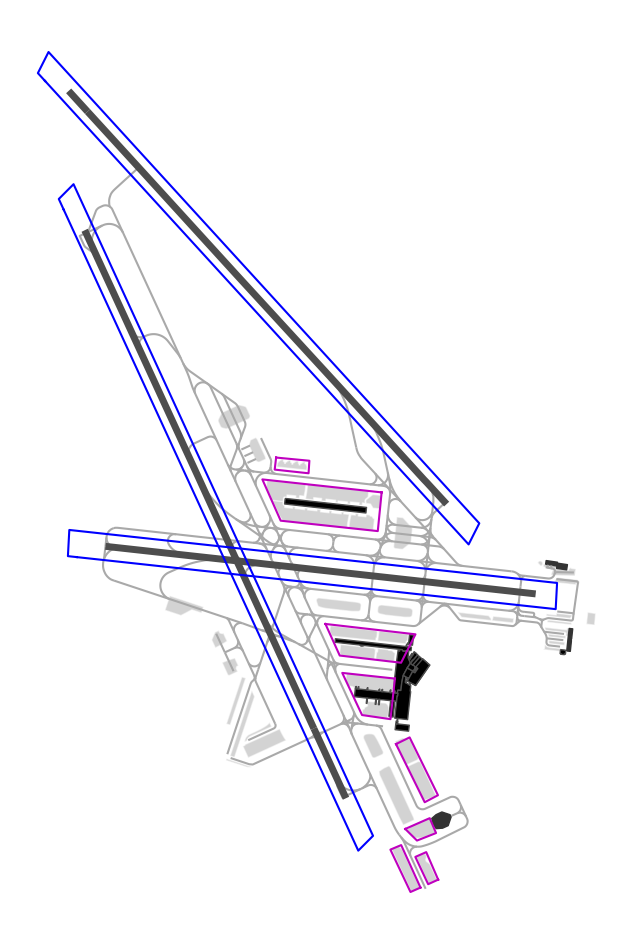

In [166]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=EuroPP()))
airports[airport_str].plot(ax, by='aeroway', aerodrome=dict(alpha=0))
ax.spines["geo"].set_visible(False)

for rwy in rwys:
    ax.plot(*rwy.exterior.xy, transform=data_proj, color = 'b')

for stand in stands:
    ax.plot(*stand.exterior.xy, transform=data_proj, color = 'm')


plt.show()

***
# Determine Take-off Runway, Taxi-Times, etc.
***

**Known issues:**
* Noisy gnd trajs -> SWR52_1040, SWR252H_992, SAZ71_1319
* Why not classified as pushback? -> SWR564_459, SWR1958_931, EDW58T_1127
* Does trajs really only start at boundary of stand? -> SXS1X_2067
* Pushback across Hotel stands -> SWR562K_902


**Missing Functionalities:**
* Filter take-offs with taxiway filter
* Implement Fuel Flow Estimation -> for Engine, APU & Tractor (see Figure 8 in Fleuti & Maraini 2017, p.16)


(0.0, 10.0)

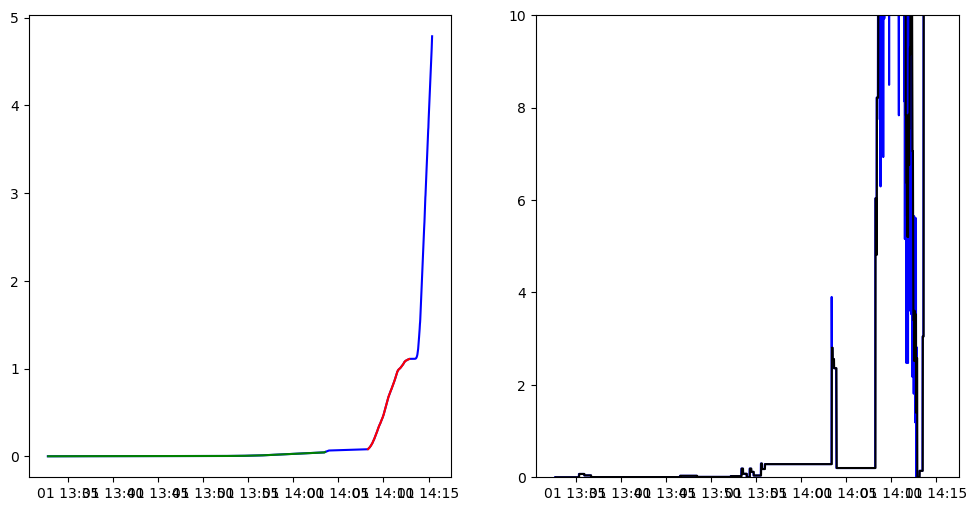

In [258]:
id = ids[22]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(gnd_trajs[id].data.timestamp,
         gnd_trajs[id].data.cumdist, 'b')

ax[0].plot(gnd_trajs[id].pushback('lszh').data.timestamp,
         gnd_trajs[id].pushback('lszh').data.cumdist, 'r')

ax[0].plot(gnd_trajs[id].on_parking_position('lszh').max().data.timestamp,
         gnd_trajs[id].on_parking_position('lszh').max().data.cumdist, 'g')

# ax[0].plot(gnd_trajs[id].clip(standsDockE).data.timestamp,
#            gnd_trajs[id].clip(standsDockE).data.cumdist, 'm')


ax[1].plot(gnd_trajs[id].data.timestamp,
           gnd_trajs[id].data.compute_gs, 'b')

ax[1].plot(gnd_trajs[id].data.timestamp,
           gnd_trajs[id].data.compute_gs.rolling(5).median(), 'k')

ax[1].set_ylim(0, 10) 




**Pusback modification**:

1. Check cumdist of pushback
2. IF larger than certain value
3. Check if trajectory.clip(standsArea) is not None
4. If this applies, use the part of compute_gs>0 which intersects with clipped part of trajectory


Example of "falsely classified pushbacks": UAE8T_2326

Example of "good" pushbacks: ACA881_2372

False


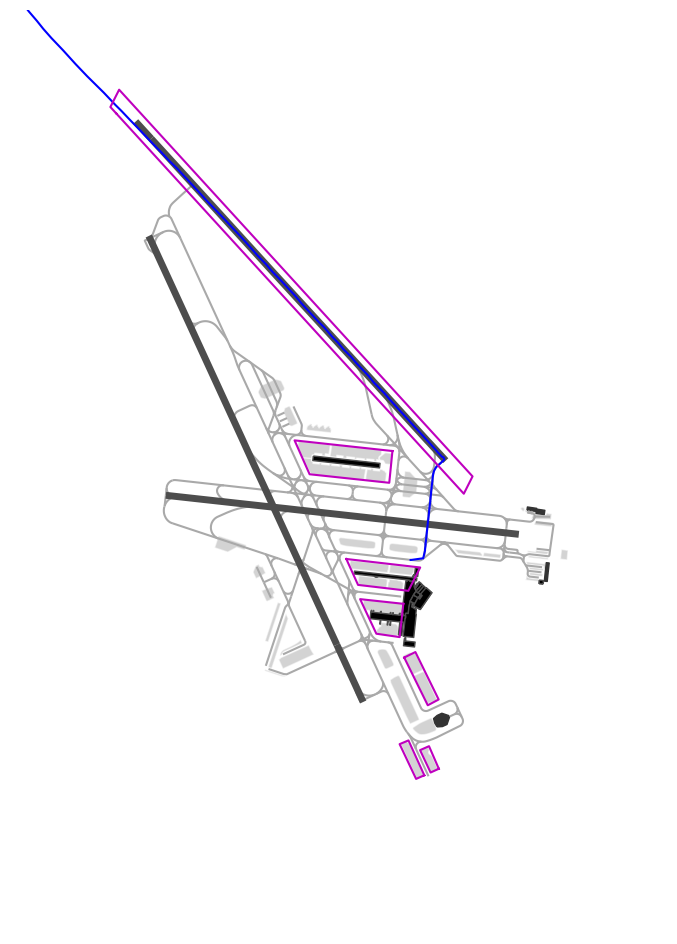

In [305]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=EuroPP()))
airports[airport_str].plot(ax, by='aeroway', aerodrome=dict(alpha=0))
ax.spines["geo"].set_visible(False)

id = 'EDW214A_1054'

gnd_trajs[id].last(minutes=60).plot(ax=ax, color='b')
ident, startPush, endPush = alternative_pushback(gnd_trajs[id], stands)

print(ident)

if ident:
    gnd_trajs[id].last(minutes=60).between(startPush, endPush).plot(ax=ax, color='r')


# gnd_trajs['AAL93_2363'].pushback('lszh').plot(ax=ax, color='r')

# gnd_trajs['KLM26J_345'].between(df_movements.iloc[244].taxi_start, df_movements.iloc[244].line_up_time).plot(ax=ax, color='r', linewidth=3)


# for id in df_movements.query('taxiDuration < "0 seconds"').flight_id:
#     gnd_trajs[id].plot(ax=ax, color='b')
#     gnd_trajs[id].pushback('lszh').plot(ax=ax, color='r')


ax.plot(*rwys[1].exterior.xy, transform=data_proj, color = 'm')

for stand in stands:
    ax.plot(*stand.exterior.xy, color = 'm', transform=data_proj)

ax.set_extent((8.5230, 8.5855, 47.4904, 47.4306))

plt.show()

### Takeoff Runway Detection

In [168]:
########
# Determine Take-off Runway (NEW, PARAELLIZED method)
########

# import warnings

# # Convert warnings to errors
# warnings.filterwarnings('error')
 
import importlib
import agps_funs
importlib.reload(agps_funs)
from agps_funs import takeoff_detection

# Get aerodrome information
df_rwys = airports[airport_str].runways.data


gnd_trajs = gnd_trajs.iterate_lazy().pipe(takeoff_detection, rwys, df_rwys, 'lszh', 60).eval(max_workers=8, desc='Takeoff Detection')

Processing:   0%|          | 0/2373 [00:00<?, ?it/s]

### Pushback Detection

In [170]:
########
# Alternative Pushback Detection Method
# Is only applicable if taxi duration is less than 0 seconds (which origin from bug in traffics flight.pushback() method)
########

importlib.reload(agps_funs)
from agps_funs import alternative_pushback_detection

gnd_trajs = gnd_trajs.iterate_lazy().pipe(alternative_pushback_detection, stands).eval(max_workers=8, desc='Pushback Detection')


Pushback Detection:   0%|          | 0/2373 [00:00<?, ?it/s]

/Users/wate/opt/miniconda3/envs/traffic/lib/python3.9/site-packages/traffic/core/flight.py:1770: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  | Callable[[pd.DataFrame], pd.DataFrame] = lambda x: x.bfill().ffill(),
/Users/wate/opt/miniconda3/envs/traffic/lib/python3.9/site-packages/traffic/core/flight.py:1770: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  | Callable[[pd.DataFrame], pd.DataFrame] = lambda x: x.bfill().ffill(),
/Users/wate/opt/miniconda3/envs/traffic/lib/python3.9/site-packages/traffic/core/flight.py:1770: FutureWarning: Downcasting object

In [171]:
gnd_trajs.to_pickle(airport_str + '_gnd.pkl')

In [ ]:
# Fuel Flow
# https://www.flughafen-zuerich.ch/-/jssmedia/airport/portal/dokumente/das-unternehmen/politics-and-responsibility/environmental-protection/technische-berichte/2017_taxi_study_zurichairport.pdf?vs=1

In [172]:
# Generate df_movements

# Group by 'flight_id'
grouped = gnd_trajs.query('takeoffRunway != ""').groupby('flight_id')

# Create a new DataFrame df_movements to store the summarized data
df_movements = pd.DataFrame()

# Extract the required information
df_movements['flight_id'] = grouped['flight_id'].first()
df_movements['callsign'] = grouped['callsign'].first()
df_movements['isPushback'] = grouped['isPushback'].first()
df_movements['startPushback'] = grouped['startPushback'].first()
df_movements['startTaxi'] = grouped['startTaxi'].first()
df_movements['lineupTime'] = grouped['lineupTime'].first()
df_movements['taxiDuration'] = grouped['taxiDuration'].first()
df_movements['takeoffRunway'] = grouped['takeoffRunway'].first()

# Reset index to get a clean DataFrame
df_movements = df_movements.reset_index(drop=True)

df_movements.to_pickle('df_movements.pkl')

### Compare takeoff_from_runway() with my method

In [77]:
# Compare 
r = []

# Iterate over each flight_id in df_movements
for flight_id in df_movements['flight_id'].values:
    
    # Get the takeoff runway for the current flight_id
    tmp = gnd_trajs[flight_id].takeoff_from_runway('lszh').next()

    # If a runway is found, append it to the list, otherwise append None or a default value
    if tmp is not None:
        r.append(tmp.data.iloc[0].runway)
    else:
        r.append(None)  # or another placeholder like 'Unknown'

# Add the list `r` as a new column in df_movements
df_movements['runway'] = r


df_movements

,flight_id,callsign,taxi_start,line_up_time,taxi_duration,takeoff_runway,runway
0,AAL93_2363,AAL93,2024-07-01 12:18:08+00:00,2024-07-01 12:21:04+00:00,0 days 00:02:56,32,32
1,AAL93_2365,AAL93,2024-07-02 09:56:57+00:00,2024-07-02 09:59:28+00:00,0 days 00:02:31,32,32
2,AEA1676_049,AEA1676,2024-07-01 09:30:26+00:00,2024-07-01 09:34:43+00:00,0 days 00:04:17,32,32
3,AEA32KC_030,AEA32KC,2024-07-01 17:14:23+00:00,2024-07-01 17:21:31+00:00,0 days 00:07:08,32,32
4,AEA32KC_036,AEA32KC,2024-07-02 16:55:06+00:00,2024-07-02 17:02:42+00:00,0 days 00:07:36,32,32
...,...,...,...,...,...,...,...
690,VLG5YD_032,VLG5YD,2024-07-02 07:46:51+00:00,2024-07-02 07:54:14+00:00,0 days 00:07:23,28,10
691,VLG5YD_045,VLG5YD,2024-07-01 10:11:19+00:00,2024-07-01 10:18:35+00:00,0 days 00:07:16,32,32
692,VLG6473_035,VLG6473,2024-07-02 13:08:22+00:00,2024-07-02 13:13:15+00:00,0 days 00:04:53,32,14
693,XAFTY_016,XAFTY,2024-07-02 13:11:14+00:00,2024-07-02 13:17:43+00:00,0 days 00:06:29,32,32


In [95]:
df_movements['is_identical'] = df_movements['TO_runway'] == df_movements['runway']
num_differences = df_movements['is_identical'].value_counts()[False]

# Percentace of differences between takeoff_from_runway() and my method:
print(num_differences/len(df_movements))

# Which runways are not identified properly?
differences = df_movements[df_movements['TO_runway'] != df_movements['runway']]
mismatched_values = differences[['flight_id', 'takeoff_runway', 'runway']]

# Group by TO_runway and runway, then count the occurrences
df_movements.groupby(['takeoff_runway', 'runway']).size().reset_index(name='count')

0.2839160839160839


,TO_runway,runway,count
0,16,16,16
1,28,10,25
2,28,28,128
3,32,10,2
4,32,14,142
5,32,16,18
6,32,28,2
7,32,32,356
8,34,16,2
9,34,34,12


### Load df_movements from pickle (only if required)

In [7]:
df_movements = pd.read_pickle('df_movements.pkl')
df_movements

,flight_id,callsign,TO_time,TO_duration,line_up_time,taxi_start,taxi_duration,TO_runway
0,AAL93_2363,AAL93,2024-07-01 12:23:51+00:00,0 days 00:01:18,2024-07-01 12:21:04+00:00,2024-07-01 12:18:08+00:00,0 days 00:02:56,32
1,ACA881_2372,ACA881,2024-07-02 12:27:31+00:00,0 days 00:01:20,2024-07-02 12:26:34+00:00,2024-07-02 12:15:01+00:00,0 days 00:11:33,32
2,AEA1676_047,AEA1676,2024-07-02 09:31:15+00:00,0 days 00:01:13,2024-07-02 09:30:33+00:00,2024-07-02 09:25:57+00:00,0 days 00:04:36,28
3,AEA1676_049,AEA1676,2024-07-01 09:35:43+00:00,0 days 00:01:08,2024-07-01 09:34:43+00:00,2024-07-01 09:30:26+00:00,0 days 00:04:17,32
4,AEA32KC_030,AEA32KC,2024-07-01 17:22:18+00:00,0 days 00:01:08,2024-07-01 17:21:31+00:00,2024-07-01 17:14:23+00:00,0 days 00:07:08,32
...,...,...,...,...,...,...,...,...
710,VLG5YD_032,VLG5YD,2024-07-02 07:56:52+00:00,0 days 00:01:06,2024-07-02 07:54:14+00:00,2024-07-02 07:49:29+00:00,0 days 00:04:45,28
711,VLG5YD_045,VLG5YD,2024-07-01 10:20:23+00:00,0 days 00:00:56,2024-07-01 10:18:35+00:00,2024-07-01 10:11:19+00:00,0 days 00:07:16,32
712,VLG6473_035,VLG6473,2024-07-02 13:13:17+00:00,0 days 00:01:22,2024-07-02 13:13:15+00:00,2024-07-02 13:08:22+00:00,0 days 00:04:53,32
713,XAFTY_016,XAFTY,2024-07-02 13:17:45+00:00,0 days 00:01:03,2024-07-02 13:17:43+00:00,2024-07-02 13:14:18+00:00,0 days 00:03:25,32


***
# Some stats
***

In [174]:
# Group by TO_runway and calculate mean and std
overview = df_movements.groupby('takeoffRunway')['taxiDuration'].agg(['count', 'mean', 'std']).reset_index()

# Display the result
overview

,takeoffRunway,count,mean,std
0,16,14,0 days 00:12:18.285714285,0 days 00:04:14.172996378
1,28,123,0 days 00:06:45.910569105,0 days 00:04:53.308767206
2,32,552,0 days 00:09:11.173913043,0 days 00:09:41.289066449
3,34,6,0 days 00:08:21.833333333,0 days 00:03:38.659933839


***
# Some illustrations
***

### Check runway classification

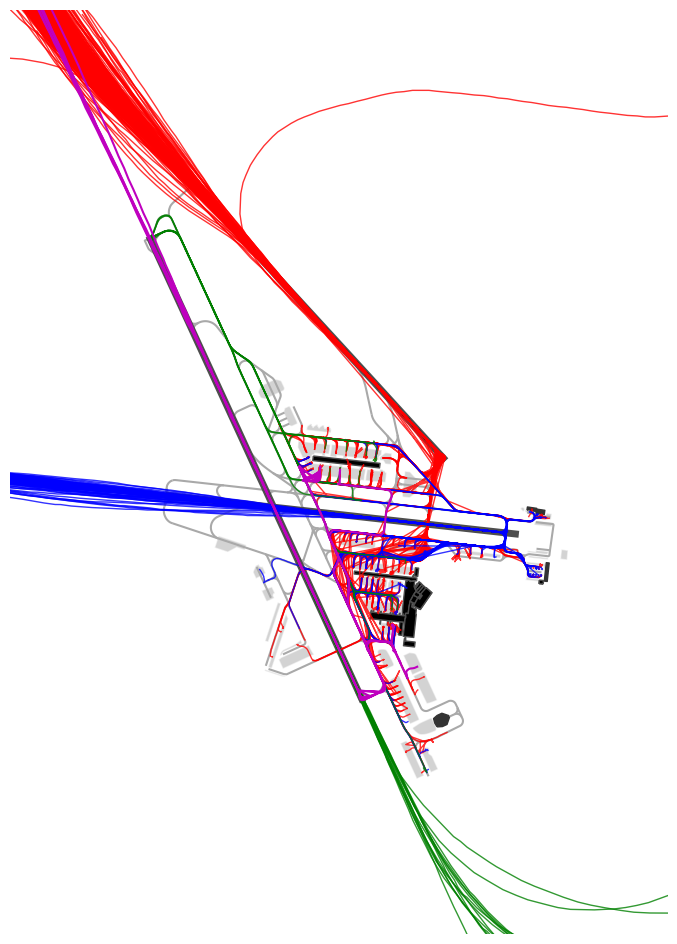

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=EuroPP()))
airports[airport_str].plot(ax, by='aeroway', aerodrome=dict(alpha=0))
ax.spines["geo"].set_visible(False)

# gnd_trajs['XAFTY_016'].plot(ax=ax, color='r')

gnd_trajs[df_movements.query('takeoff_runway == "32"').flight_id.values].plot(ax=ax, color='r')
gnd_trajs[df_movements.query('takeoff_runway == "28"').flight_id.values].plot(ax=ax, color='b')
gnd_trajs[df_movements.query('takeoff_runway == "16"').flight_id.values].plot(ax=ax, color='g')
gnd_trajs[df_movements.query('takeoff_runway == "34"').flight_id.values].plot(ax=ax, color='m')
# gnd_trajs[df_movements.query('TO_runway == "10"').flight_id.values].plot(ax=ax, color='y')

ax.set_extent((8.5230, 8.5855, 47.4904, 47.4306))

### Plot taxi-part of trajs only

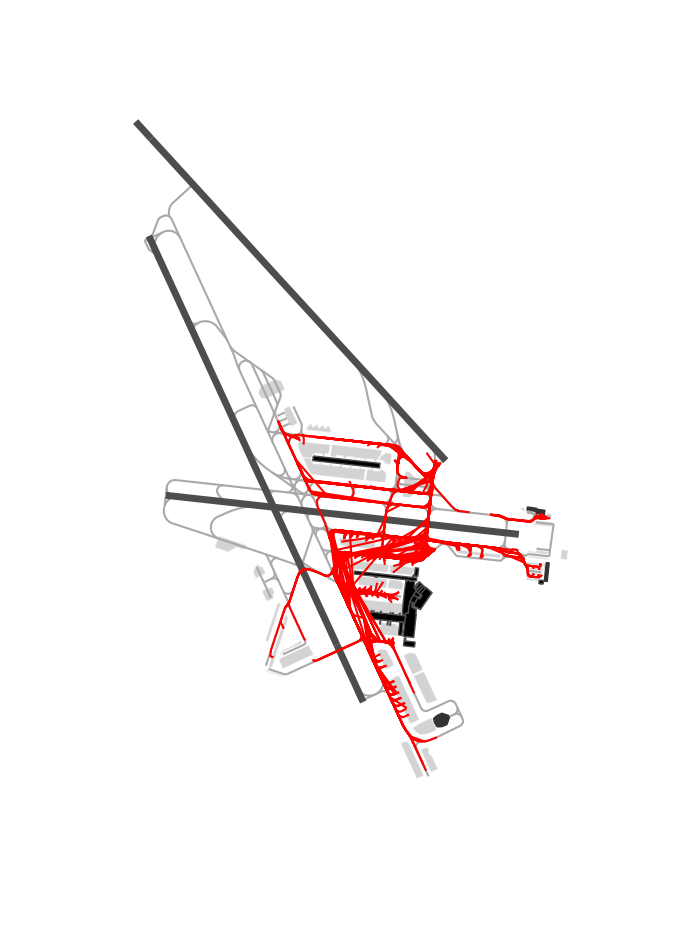

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=EuroPP()))
airports[airport_str].plot(ax, by='aeroway', aerodrome=dict(alpha=0))
ax.spines["geo"].set_visible(False)


df_movements_rwy = df_movements.query('TO_runway == "32"')

flt_ids = df_movements_rwy.flight_id.values


for i, flt_id in enumerate(flt_ids):
    gnd_trajs[flt_id].between(df_movements_rwy.iloc[i].taxi_start, df_movements_rwy.iloc[i].line_up_time).plot(ax=ax, color='r')

ax.set_extent((8.5230, 8.5855, 47.4904, 47.4306))

In [178]:
from matplotlib.backends.backend_pdf import PdfPages

idxs = df_movements.index
number_of_pages = 40
number_of_trajs_per_page = 4

colors = ['r', 'b', 'g', 'y']

# Create a PDF file
with PdfPages('check_flights.pdf') as pdf:

    np.random.seed()

    for page in range(number_of_pages):

        ids = np.random.choice(idxs, size=number_of_trajs_per_page, replace=False)

        fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=EuroPP()))
        airports[airport_str].plot(ax, by='aeroway', aerodrome=dict(alpha=0))
        ax.spines["geo"].set_visible(False)
        ax.set_extent((8.5230, 8.5855, 47.4904, 47.4306))

        for i, idx in enumerate(ids):
            
            id = df_movements.loc[idx, 'flight_id']

            gnd_trajs[id].plot(ax=ax, color=colors[i], label=id)

            gnd_trajs[id].between(df_movements.iloc[idx].startTaxi, df_movements.iloc[idx].lineupTime).plot(ax=ax, color=colors[i], linewidth=3)

            if df_movements.loc[idx, 'isPushback']:
                gnd_trajs[id].between(df_movements.iloc[idx].startPushback, df_movements.iloc[idx].startTaxi).plot(ax=ax, color='m', linewidth=3)
            

        plt.legend(loc='upper right')
        pdf.savefig()  # saves the current figure into the pdf
        plt.close()  # close the figure after saving to pdf

 